# Poisson Metropolis-Hastings MCMC

Generate samples from a Poisson distribution

$$
  p(x|\lambda)=\frac{\lambda^x~e^{-\lambda}}{x!}
$$

using Metropolis-Hastings. This example comes from *Bayesian Logical Data Analysis* by Phil Gregory. The proposal distribution is just a random walk, so the algorithm proceeds as follows:

1. Given $x_t$, pick a random uniform $u_1\sim U(0,1).$
1. Pick a proposal move:
    - If $u_1>0.5$, then $y=x_t+1$.
    - Else, $y=x_t-1$.
1. Compute the M-H ratio: $r=p(y|\lambda)/p(x_t|\lambda)=\lambda^{y-x_t}~x_t!/y!$
1. Generate $u_2\sim U(0,1)$.
1. Accept or reject the proposal:
    - If $u_2\leq r$ then $x_t\to x_{t+1}=y$.
    - Else $x_t\to x_{t+1}=x_t$.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln

mpl.rc('font', size=18)
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', serif='palatino')

## Generate the Sample

Produce 20,000 samples from $p(x|\lambda)$ using $\lambda=3$ and starting at $x_{t=0}=25$.

In [2]:
np.random.seed(13)

mu = 3. # Poisson mean
x = 25. # MCMC seed
xt = []

for i in range(20000):
    xt.append(x)
    u1, u2 = np.random.uniform(0.,1., size=2)
    y = x+1 if u1 > 0.5 else x-1
    
    r = np.exp((y-x)*np.log(mu) + gammaln(x+1) - gammaln(y+1))
    if u2 <= r:
        x = y

## Inspect Results

### Plot First 1000 Samples

This should make the burn-in visible.

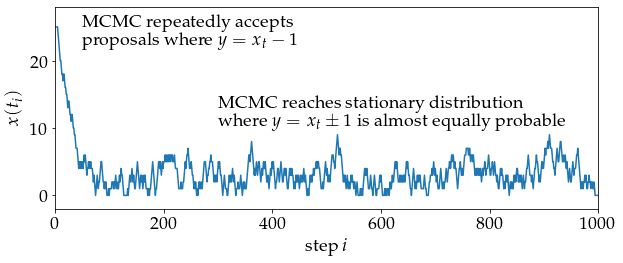

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(xt)
ax.set(xlim=(0,1000),
       xlabel='step $i$',
       ylim=(-2,28),
       ylabel='$x(t_i)$')

ax.text(50,22, 'MCMC repeatedly accepts\nproposals where $y=x_t-1$')
ax.text(300,10, 'MCMC reaches stationary distribution\nwhere $y=x_t\\pm1$ is almost equally probable')
fig.tight_layout();

### Histogram Samples after Burn-In

Play it super-safe and histogram the samples starting at $x_{t=150}$.

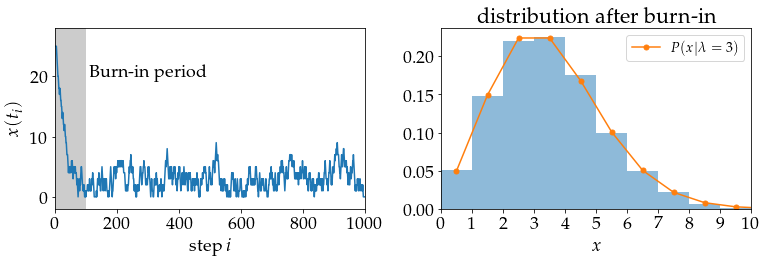

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
ax1.plot(xt)
ax1.set(xlim=(0,1000),
        xlabel='step $i$',
        ylim=(-2,28),
        ylabel='$x(t_i)$')
rect = mpl.patches.Rectangle((0,-2), 100, 30, ec="None", fc="gray", alpha=0.4)
ax1.add_patch(rect)
ax1.text(110, 20, "Burn-in period")

# Histogram samples after burn-in.
ax2.hist(xt[150:], bins=np.linspace(0,10,11),
         histtype='stepfilled',
         density=True,
         alpha=0.5)
ax2.plot(0.5 + np.linspace(0,10,11),
         poisson.pmf(np.linspace(0,10,11), mu), '.-', ms=10,
         label=r'$P(x|\lambda=3)$')
ax2.set(xlim=(0,10),
        xlabel='$x$',
        title='distribution after burn-in')
ax2.xaxis.set_major_locator(mpl.ticker.LinearLocator(11))
ax2.legend(fontsize=14)
fig.tight_layout();

## Autocorrelation Function

Plot the autocorrelation of the data as a function of lag. Note that [emcee](https://emcee.readthedocs.io/en/stable/) has code to do this for you.

In [5]:
def acf(x):
    """Compute the autocorrelation of the array.
    """
    data = np.asarray(x)
    n = data.size
    mean = np.mean(data)
    c0 = np.sum((data - mean)**2) / float(n)
    def r(h):
        acfLag = ((data[:n-h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return round(acfLag, 3)
    t = np.arange(n)
    return list(map(r,t))

### Plot the Autocorrelation

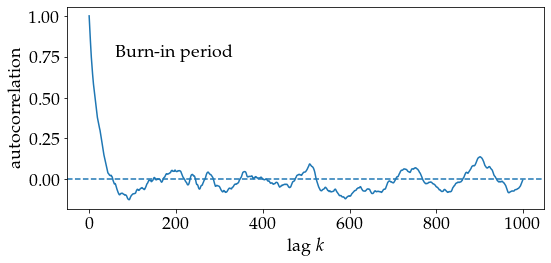

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(acf(xt[:1000]))
ax.set_xlabel('lag $k$')
ax.set_ylabel('autocorrelation')
ax.axhline(0, ls="--")
ax.text(60, 0.75, 'Burn-in period')
fig.tight_layout();